In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir("drive/My Drive/Shell")

Mounted at /content/drive


In [161]:
import numpy as np
import pandas as pd
import random
import numpy  as np
import pandas as pd    
from numba import njit                        # For some speed gains                    
from math import radians as DegToRad          # Degrees to radians Conversion
from shapely.geometry import Point            # Used in constraint checking
from shapely.geometry.polygon import Polygon
from tqdm import tqdm                         # For Progressbar
import warnings


# Genetic Algorithm for Turbine Points Layout
1. Gene for this problem would be x,y co-ordinates of one turbine.
2. Chromosome would be 50 x,y co-ordinates for 50 turbines(farmLayout design).
3. There are two constraints in this problem.They are Proximity and perimeter constraints. 
4. Total Aep Value would be calculated based on each chromosome and elite population is found.
5. Crossover Strategy: it takes top 4 layouts provided by sample elite population function as input and randomly picks some 50 points out of them and creates one child layout and adds it to the sample elite population.so that if the child is better than the parents then it will be picked as top layout if not parents will be picked.
6. Mutation Strategy:it takes top 4 layout provided by sample elite population function as input and selects one random layout out of the 4 layouts. from that one layout it retains 30 points and randomly generates 20 new points and adds to it to create one mutated child of 50 points and adds this child to the top 4 layouts.so if the mutated child is better than the parent it will be picked up as top layout if not our sample elite population will be retained in the next iteration.


# Chromosomes

In [163]:
def st_layout():
  a=[483,916,1349,1782,2215,2648,3081,3514]
  b=[]
  for i in range(len(a)):
      b.append([a[i],50])
      b.append([a[i],3947])
      b.append([50,a[i]])
      b.append([3947,a[i]])
  b.append([50,3947])
  b.append([50,50])
  b.append([3947,50])
  b.append([3947,3947])
  return b



#---------------------------------------------------------------------------------------------------------------------#



def newpoint():
    while(True):
        random = np.random.rand(1,2)*4000
        if (random[0,0]>50 and random[0,0]<3950) and (random[0,1]>50 and random[0,1]<3950):
            return random.tolist()[0]
        
#---------------------------------------------------------------------------------------------------------------------#

def distance(A,B):
    return ((A[0]-B[0])**2+(A[1]-B[1])**2)**0.5

#---------------------------------------------------------------------------------------------------------------------#

def constraint_checker_for_new_point(point,layout: list) -> bool:

    for i in layout:
        if abs(distance(point,i))<=400:
            return False
    return True

#---------------------------------------------------------------------------------------------------------------------#

def fn_chromosome():
    k = st_layout()
    np.random.shuffle(k)
    a=k[:20]
    #a.append(newpoint())
    count=0
    while(len(a)!=50):
        new = newpoint()
        if constraint_checker_for_new_point(new,a):
            a.append(new)
            count+=1
    final = np.array(a).reshape(50,2)
    final = pd.DataFrame(final,columns=["x","y"])
    return final

#---------------------------------------------------------------------------------------------------------------------#

def fn_plot(s):
    plt.scatter(s['x'],s['y'])
    plt.xlabel('x axis')
    plt.ylabel('y axis')
    plt.show()

#---------------------------------------------------------------------------------------------------------------------#

def fn_generate_initial_population(population_size):
    init_population_list = []
    init_population_list = [fn_chromosome() for _ in range(population_size)]
    return init_population_list

# Optimization Function



In [142]:
def fn_fitness_function(turb_loc_list):
        # -*- coding: utf-8 -*-
    """
    Created on: xxxx
    @author   : Anon

    NAME
        Farm_Evalautor.py

    PYTHON VERSION   
        3.7.3 

    DESCRIPTION
        Calculates Annual Energy Production (AEP) of a Wind Farm
        ============================================================    

        This is vectorzied version of Farm_Evalautor.py. 
        Farm_Evalautor_Vec.py is a python file that calculates AEP (GWh)
        of a certain arrangement of wind turbines in a farm, under 
        given annual wind conditions. 

        The code in this script for wake-effect modeling is based on
        standard Jensen (PARK) model. 
        I. Katic, J. Hojstrup and N. Jensen, "A simple model for cluster 
        efficiency," in European Wind Energy Association Conference and 
        Exhibition, 1986.

        As its inputs, the code takes three data files containing info 
        about:
        - Turbine Locations
        - Turbine Power Curve
        - Annual Wind Conditions

    PACKAGE LIST
        You may need to install the package Shapely in your
        python distribution. These are not pre-installed. 
        =============================================================
        Packages Used:
        Numpy
        Pandas
        Shapely
        math (built-in)

    OPTIMIZATION USAGE
        This vectorized version is faster than unvectorized version
        Farm_Evalautor.py. Due to speed benefits, we advise you to use 
        the function getAEP in this script while developing the optimizer. 
        =============================================================

        One way to use getAEP function as AEP evaluator while optimizing is:
        - STEP 1. Import the relevant function from Farm_Evalautor_Vec. 
                  from Farm_Evalautor_Vec import getTurbLoc, loadPowerCurve, 
                  binWindResourceData, preProcessing, getAEP
        - STEP 2. Set Turbine Radius to 50.0. First arg of getAEP
        - STEP 3. Load Turbine Locations. Using function getTurbLoc
        - STEP 4. Load Power Curve. Using function loadPowerCurve
        - STEP 5. Load wind instance probabilities. 
                  Using function binWindResourceData
        - STEP 6. Perform Preprocessing by calling function preProcessing.
                  We do preprocessing to avoid same repeating calculations.
                  Do them once. 
        - STEP 7. Finally, call function getAEP

        This makes it easy to control the reloading of data and hence achieve
        better performance.      
    """

    # Module List                   
    warnings.filterwarnings("ignore")

    def getTurbLoc(turb_loc_file_name):
        """ 
        -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-

        Returns x,y turbine coordinates

        :Called from
            main function

        :param
            turb_loc_file_name - Turbine Loc csv file location

        :return
            2D array
        """

        df = pd.read_csv(turb_loc_file_name, sep=',', dtype = np.float32)
        turb_coords = df.to_numpy(dtype = np.float32)
        return(turb_coords)
    
    def getTurblocation(turb_loc_list):
        turb_coords = np.array(turb_loc_list)
        return(turb_coords)



    def loadPowerCurve(power_curve_file_name):
        """
        -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-

        Returns a 2D numpy array with information about
        turbine thrust coeffecient and power curve of the 
        turbine for given wind speed

        :called_from
            main function

        :param
            power_curve_file_name - power curve csv file location

        :return
            Returns a 2D numpy array with cols Wind Speed (m/s), 
            Thrust Coeffecient (non dimensional), Power (MW)
        """
        powerCurve = pd.read_csv(power_curve_file_name, sep=',', dtype = np.float32)
        powerCurve = powerCurve.to_numpy(dtype = np.float32)
        return(powerCurve)


    def binWindResourceData(wind_data_file_name):
        r"""
        -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-

        Loads the wind data. Returns a 2D array with shape (36,15). 
        Each cell in  array is a wind direction and speed 'instance'. 
        Values in a cell correspond to probability of instance
        occurence.  

        :Called from
            main function

        :param
            wind_data_file_name - Wind Resource csv file  

        :return
            1-D flattened array of the 2-D array shown below. Values 
            inside cells, rough probabilities of wind instance occurence. 
            Along: Row-direction (drct), Column-Speed (s). Array flattened
            for vectorization purpose. 

                          |0<=s<2|2<=s<4| ...  |26<=s<28|28<=s<30|
            |_____________|______|______|______|________|________|
            | drct = 360  |  --  |  --  |  --  |   --   |   --   |
            | drct = 10   |  --  |  --  |  --  |   --   |   --   |
            | drct = 20   |  --  |  --  |  --  |   --   |   --   |
            |   ....      |  --  |  --  |  --  |   --   |   --   |
            | drct = 340  |  --  |  --  |  --  |   --   |   --   |
            | drct = 350  |  --  |  --  |  --  |   --   |   --   |        
        """

        # Load wind data. Then, extracts the 'drct', 'sped' columns
        df = pd.read_csv(wind_data_file_name)
        wind_resource = df[['drct', 'sped']].to_numpy(dtype = np.float32)

        # direction 'slices' in degrees
        slices_drct   = np.roll(np.arange(10, 361, 10, dtype=np.float32), 1)
        ## slices_drct   = [360, 10.0, 20.0.......340, 350]
        n_slices_drct = slices_drct.shape[0]

        # speed 'slices'
        slices_sped   = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 
                            18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
        n_slices_sped = len(slices_sped)-1


        # placeholder for binned wind
        binned_wind = np.zeros((n_slices_drct, n_slices_sped), 
                               dtype = np.float32)

        # 'trap' data points inside the bins. 
        for i in range(n_slices_drct):
            for j in range(n_slices_sped):     

                # because we already have drct in the multiples of 10
                foo = wind_resource[(wind_resource[:,0] == slices_drct[i])] 

                foo = foo[(foo[:,1] >= slices_sped[j]) 
                              & (foo[:,1] <  slices_sped[j+1])]

                binned_wind[i,j] = foo.shape[0]  

        wind_inst_freq   = binned_wind/np.sum(binned_wind)
        wind_inst_freq   = wind_inst_freq.ravel()

        return(wind_inst_freq)
    def wind_avg():
        wind_arr_2017 = binWindResourceData('Shell_Hackathon_Dataset/Wind Data/wind_data_2017.csv')
        wind_arr_2015 = binWindResourceData('Shell_Hackathon_Dataset/Wind Data/wind_data_2015.csv')
        wind_arr_2014 = binWindResourceData('Shell_Hackathon_Dataset/Wind Data/wind_data_2014.csv')
        weight_1 = 0.3
        weight_2 = 0.34
        weight_3 = 0.36
        wind_avg = np.average([wind_arr_2017, wind_arr_2015,wind_arr_2014], axis = 0, weights=[weight_1, weight_2,weight_3])
        return wind_avg

    def searchSorted(lookup, sample_array):
        """
        -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-

        Returns lookup indices for closest values w.r.t sample_array elements

        :called_from
            preProcessing, getAEP

        :param
            lookup       - The lookup array
            sample_array - Array, whose elements need to be matched
                           against lookup elements. 

        :return
            lookup indices for closest values w.r.t sample_array elements 
        """
        lookup_middles = lookup[1:] - np.diff(lookup.astype('f'))/2
        idx1 = np.searchsorted(lookup_middles, sample_array)
        indices = np.arange(lookup.shape[0])[idx1]
        return indices



    def preProcessing(power_curve):
        """
        -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-

        Doing preprocessing to avoid the same repeating calculations.
        Record the required data for calculations. Do that once.
        Data are set up (shaped) to assist vectorization. Used later in
        function totalAEP. 

        :called_from
            main function

        :param
            power_curve - 2D numpy array with cols Wind Speed (m/s), 
                          Thrust Coeffecient (non dimensional), Power (MW)

        :return
            n_wind_instances  - number of wind instances (int)
            cos_dir           - For coordinate transformation 
                                2D Array. Shape (n_wind_instances,1)
            sin_dir           - For coordinate transformation 
                                2D Array. Shape (n_wind_instances,1)
            wind_sped_stacked - column staked all speed instances n_turb times. 
            C_t               - 3D array with shape (n_wind_instances, n_turbs, n_turbs)
                                Value changing only along axis=0. C_t, thrust coeff.
                                values for all speed instances. 
        """
        # number of turbines
        n_turbs       =   50

        # direction 'slices' in degrees
        slices_drct   = np.roll(np.arange(10, 361, 10, dtype=np.float32), 1)
        ## slices_drct   = [360, 10.0, 20.0.......340, 350]
        n_slices_drct = slices_drct.shape[0]

        # speed 'slices'
        slices_sped   = [0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0, 
                            18.0, 20.0, 22.0, 24.0, 26.0, 28.0, 30.0]
        n_slices_sped = len(slices_sped)-1

        # number of wind instances
        n_wind_instances = (n_slices_drct)*(n_slices_sped)

        # Create wind instances. There are two columns in the wind instance array
        # First Column - Wind Speed. Second Column - Wind Direction
        # Shape of wind_instances (n_wind_instances,2). 
        # Values [1.,360.],[3.,360.],[5.,360.]...[25.,350.],[27.,350.],29.,350.]
        wind_instances = np.zeros((n_wind_instances,2), dtype=np.float32)
        counter = 0
        for i in range(n_slices_drct):
            for j in range(n_slices_sped): 

                wind_drct =  slices_drct[i]
                wind_sped = (slices_sped[j] + slices_sped[j+1])/2

                wind_instances[counter,0] = wind_sped
                wind_instances[counter,1] = wind_drct
                counter += 1

        # So that the wind flow direction aligns with the +ve x-axis.			
        # Convert inflow wind direction from degrees to radians
        wind_drcts =  np.radians(wind_instances[:,1] - 90)
        # For coordinate transformation 
        cos_dir = np.cos(wind_drcts).reshape(n_wind_instances,1)
        sin_dir = np.sin(wind_drcts).reshape(n_wind_instances,1)

        # create copies of n_wind_instances wind speeds from wind_instances
        wind_sped_stacked = np.column_stack([wind_instances[:,0]]*n_turbs)

        # Pre-prepare matrix with stored thrust coeffecient C_t values for 
        # n_wind_instances shape (n_wind_instances, n_turbs, n_turbs). 
        # Value changing only along axis=0. C_t, thrust coeff. values for all 
        # speed instances.
        # we use power_curve data as look up to estimate the thrust coeff.
        # of the turbine for the corresponding closest matching wind speed
        indices = searchSorted(power_curve[:,0], wind_instances[:,0])
        C_t     = power_curve[indices,1]
        # stacking and reshaping to assist vectorization
        C_t     = np.column_stack([C_t]*(n_turbs*n_turbs))
        C_t     = C_t.reshape(n_wind_instances, n_turbs, n_turbs)

        return(n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t)


    def getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t):

        """
        -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-

        Calculates AEP of the wind farm. Vectorised version.

        :called from
            main

        :param
            turb_diam         - Radius of the turbine (m)
            turb_coords       - 2D array turbine euclidean x,y coordinates
            power_curve       - For estimating power. 
            wind_inst_freq    - 1-D flattened with rough probabilities of 
                                wind instance occurence.
                                n_wind_instances  - number of wind instances (int)
            cos_dir           - For coordinate transformation 
                                2D Array. Shape (n_wind_instances,1)
            sin_dir           - For coordinate transformation 
                                2D Array. Shape (n_wind_instances,1)
            wind_sped_stacked - column staked all speed instances n_turb times. 
            C_t               - 3D array with shape (n_wind_instances, n_turbs, n_turbs)
                                Value changing only along axis=0. C_t, thrust coeff.
                                values for all speed instances. 

        :return
            wind farm AEP in Gigawatt Hours, GWh (float)
        """
        # number of turbines
        n_turbs        =   turb_coords.shape[0]
        assert n_turbs ==  50, "Error! Number of turbines is not 50."

        # Prepare the rotated coordinates wrt the wind direction i.e downwind(x) & crosswind(y) 
        # coordinates wrt to the wind direction for each direction in wind_instances array
        rotate_coords   =  np.zeros((n_wind_instances, n_turbs, 2), dtype=np.float32)
        # Coordinate Transformation. Rotate coordinates to downwind, crosswind coordinates
        rotate_coords[:,:,0] =  np.matmul(cos_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) - \
                               np.matmul(sin_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))
        rotate_coords[:,:,1] =  np.matmul(sin_dir, np.transpose(turb_coords[:,0].reshape(n_turbs,1))) +\
                               np.matmul(cos_dir, np.transpose(turb_coords[:,1].reshape(n_turbs,1)))


        # x_dist - x dist between turbine pairs wrt downwind/crosswind coordinates)
        # for each wind instance
        x_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
        for i in range(n_wind_instances):
            tmp = rotate_coords[i,:,0].repeat(n_turbs).reshape(n_turbs, n_turbs)
            x_dist[i] = tmp - tmp.transpose()


        # y_dist - y dist between turbine pairs wrt downwind/crosswind coordinates)
        # for each wind instance    
        y_dist = np.zeros((n_wind_instances,n_turbs,n_turbs), dtype=np.float32)
        for i in range(n_wind_instances):
            tmp = rotate_coords[i,:,1].repeat(n_turbs).reshape(n_turbs, n_turbs)
            y_dist[i] = tmp - tmp.transpose()
        y_dist = np.abs(y_dist) 


        # Now use element wise operations to calculate speed deficit.
        # kw, wake decay constant presetted to 0.05
        # use the jensen's model formula. 
        # no wake effect of turbine on itself. either j not an upstream or wake 
        # not happening on i because its outside of the wake region of j
        # For some values of x_dist here RuntimeWarning: divide by zero may occur
        # That occurs for negative x_dist. Those we anyway mark as zeros. 
        sped_deficit = (1-np.sqrt(1-C_t))*((turb_rad/(turb_rad + 0.05*x_dist))**2) 
        sped_deficit[((x_dist <= 0) | ((x_dist > 0) & (y_dist > (turb_rad + 0.05*x_dist))))] = 0.0


        # Calculate Total speed deficit from all upstream turbs, using sqrt of sum of sqrs
        sped_deficit_eff  = np.sqrt(np.sum(np.square(sped_deficit), axis = 2))


        # Element wise multiply the above with (1- sped_deficit_eff) to get
        # effective windspeed due to the happening wake
        wind_sped_eff     = wind_sped_stacked*(1.0-sped_deficit_eff)


        # Estimate power from power_curve look up for wind_sped_eff
        indices = searchSorted(power_curve[:,0], wind_sped_eff.ravel())
        power   = power_curve[indices,2]
        power   = power.reshape(n_wind_instances,n_turbs)

        # Farm power for single wind instance 
        power   = np.sum(power, axis=1)

        # multiply the respective values with the wind instance probabilities 
        # year_hours = 8760.0
        AEP = 8760.0*np.sum(power*wind_inst_freq)

        # Convert MWh to GWh
        AEP = AEP/1e3

        return(AEP)



    def checkConstraints(turb_coords, turb_diam):
        """
        -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-

        Checks if the turbine configuration satisfies the two
        constraints:(i) perimeter constraint,(ii) proximity constraint 
        Prints which constraints are violated if any. Note that this 
        function does not quantifies the amount by which the constraints 
        are violated if any. 

        :called from
            main 

        :param
            turb_coords - 2d np array containing turbine x,y coordinates
            turb_diam   - Diameter of the turbine (m)

        :return
            None. Prints messages.   
        """
        bound_clrnc      = 50
        prox_constr_viol = False
        peri_constr_viol = False

        # create a shapely polygon object of the wind farm
        farm_peri = [(0, 0), (0, 4000), (4000, 4000), (4000, 0)]
        farm_poly = Polygon(farm_peri)

        # checks if for every turbine perimeter constraint is satisfied. 
        # breaks out if False anywhere
        for turb in turb_coords:
            turb = Point(turb)
            inside_farm   = farm_poly.contains(turb)
            correct_clrnc = farm_poly.boundary.distance(turb) >= bound_clrnc
            if (inside_farm == False or correct_clrnc == False):
                peri_constr_viol = True
                break

        # checks if for every turbines proximity constraint is satisfied. 
        # breaks out if False anywhere
        for i,turb1 in enumerate(turb_coords):
            for turb2 in np.delete(turb_coords, i, axis=0):
                if  np.linalg.norm(turb1 - turb2) < 4*turb_diam:
                    prox_constr_viol = True
                    break

        # print messages
        if  peri_constr_viol  == True  and prox_constr_viol == True:
              print('Somewhere both perimeter constraint and proximity constraint are violated\n')
        elif peri_constr_viol == True  and prox_constr_viol == False:
              print('Somewhere perimeter constraint is violated\n')
        elif peri_constr_viol == False and prox_constr_viol == True:
              print('Somewhere proximity constraint is violated\n')
        else: print('Both perimeter and proximity constraints are satisfied !!\n')

        return()

    if __name__ == "__main__":

        # Turbine Specifications.
        # -**-SHOULD NOT BE MODIFIED-**-
        turb_specs    =  {   
                             'Name': 'Anon Name',
                             'Vendor': 'Anon Vendor',
                             'Type': 'Anon Type',
                             'Dia (m)': 100,
                             'Rotor Area (m2)': 7853,
                             'Hub Height (m)': 100,
                             'Cut-in Wind Speed (m/s)': 3.5,
                             'Cut-out Wind Speed (m/s)': 25,
                             'Rated Wind Speed (m/s)': 15,
                             'Rated Power (MW)': 3
                         }
        turb_diam      =  turb_specs['Dia (m)']
        turb_rad       =  turb_diam/2 

        # Turbine x,y coordinates
        #turb_coords   =  getTurbLoc(r'..\Shell_Hackathon Dataset\turbine_loc_test.csv')
        turb_coords      =  getTurblocation(turb_loc_list)

        # Load the power curve
        power_curve   =  loadPowerCurve("Shell_Hackathon Dataset/power_curve.csv")

        # Pass wind data csv file location to function binWindResourceData.
        # Retrieve probabilities of wind instance occurence.
        #wind_inst_freq =  binWindResourceData(r'..\Shell_Hackathon Dataset\Wind Data\wind_data_2007.csv')
        wind_inst_freq = wind_avg()

        # Doing preprocessing to avoid the same repeating calculations. Record 
        # the required data for calculations. Do that once. Data are set up (shaped)
        # to assist vectorization. Used later in function totalAEP.
        n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t = preProcessing(power_curve)

        # check if there is any constraint is violated before we do anything. Comment 
        # out the function call to checkConstraints below if you desire. Note that 
        # this is just a check and the function does not quantifies the amount by 
        # which the constraints are violated if any. 
        checkConstraints(turb_coords, turb_diam)

        print('Calculating AEP......')
        AEP = getAEP(turb_rad, turb_coords, power_curve, wind_inst_freq, 
                      n_wind_instances, cos_dir, sin_dir, wind_sped_stacked, C_t) 
        print('Total power produced by the wind farm is: ', "%.12f"%(AEP), 'GWh')

    return AEP

In [143]:
turb_diam = 100

#Constraints

In [144]:
def checkConstraints(turb_coords, turb_diam):
        """
        -**-THIS FUNCTION SHOULD NOT BE MODIFIED-**-

        Checks if the turbine configuration satisfies the two
        constraints:(i) perimeter constraint,(ii) proximity constraint 
        Prints which constraints are violated if any. Note that this 
        function does not quantifies the amount by which the constraints 
        are violated if any. 

        :called from
            main 

        :param
            turb_coords - 2d np array containing turbine x,y coordinates
            turb_diam   - Diameter of the turbine (m)

        :return
            None. Prints messages.   
        """
        bound_clrnc      = 50
        prox_constr_viol = False
        peri_constr_viol = False

        # create a shapely polygon object of the wind farm
        farm_peri = [(0, 0), (0, 4000), (4000, 4000), (4000, 0)]
        farm_poly = Polygon(farm_peri)

        # checks if for every turbine perimeter constraint is satisfied. 
        # breaks out if False anywhere
        for turb in turb_coords:
            turb = Point(turb)
            inside_farm   = farm_poly.contains(turb)
            correct_clrnc = farm_poly.boundary.distance(turb) >= bound_clrnc
            if (inside_farm == False or correct_clrnc == False):
                peri_constr_viol = True
                break

        # checks if for every turbines proximity constraint is satisfied. 
        # breaks out if False anywhere
        for i,turb1 in enumerate(turb_coords):
            for turb2 in np.delete(turb_coords, i, axis=0):
                if  np.linalg.norm(turb1 - turb2) < 4*turb_diam:
                    prox_constr_viol = True
                    break

        # print messages
        if  peri_constr_viol  == True  and prox_constr_viol == True:
              print('Somewhere both perimeter constraint and proximity constraint are violated\n')
        elif peri_constr_viol == True  and prox_constr_viol == False:
              print('Somewhere perimeter constraint is violated\n')
        elif peri_constr_viol == False and prox_constr_viol == True:
              print('Somewhere proximity constraint is violated\n')
        else: print('Both perimeter and proximity constraints are satisfied !!\n')

        return()


# Evolution

## 1.Crossover

In [147]:
#randomly choose 50 coordinates from top 4 layouts and check if they are satisfying constraints 
def fn_crossover(layout_list):
    layout = layout_list.copy()
    flattened_df = pd.DataFrame(columns = ['x','y'])
    flattened_df =pd.concat(layout_list)
    flattened_df = flattened_df.sample(frac = 1) 
    flattened_df.reset_index(drop = True, inplace =True)
    Xover_coords = flattened_df.to_numpy()
    candidate_index = np.random.randint(low = 0,  high=Xover_coords.shape[0], size=1)
    df = pd.DataFrame(index = [0],columns = ['x','y'])
    df.loc[0] = Xover_coords[candidate_index]
    Xover_coords = np.delete(Xover_coords, candidate_index, axis = 0)
    
                # checks if for every turbine perimeter constraint is satisfied. 
                # breaks out if False anywhere
                # for turb in mutant_coords:
                # turb = Point(turb)
                # inside_farm   = farm_poly.contains(turb)
                # correct_clrnc = farm_poly.boundary.distance(turb) >= bound_clrnc
                # if (inside_farm == False or correct_clrnc == False):
                    #peri_constr_viol = True
                    #break
                # checks if for every turbines proximity constraint is satisfied. 
                # breaks out if False anywhere
                
          
    for i,turb1 in enumerate(Xover_coords):
        
        flag = 0
        #for turb2 in np.delete(df, i, axis=0):
        for j in range(df.shape[0]):
            turb2 = np.array(df.iloc[j])
            #turb2 = np.array(turb2)
            #print(type(turb1))
            #print(turb2)
            if  np.linalg.norm(turb1 - turb2) < 4*turb_diam:
                flag = 1
                break
                
        if flag ==0: 
            
            #df.loc[len(df),'x'] = turb1[0]
            #df.loc[(len(df)-1),'y'] = turb1[1]
            
            df.loc[len(df)] = turb1
            if (len(df)==50):
                break
            
                #crossover_list.append(turb1)
                
                #    np.unique(a, axis=0)


        
        
    #return df
    #layout.append(df)
    return df

## 2.Choose Elite

In [155]:
def fn_sample_elite(new_population,iteration_no):
    AEP_df = pd.DataFrame(columns = ['AEP','iteration_num'])
    
    for i in range (len(new_population)):
        AEP_df.loc[len(AEP_df),'iteration_num'] = iteration_no
        AEP_df.loc[(len(AEP_df)-1),'AEP'] = fn_fitness_function(new_population[i])

     
    elite = AEP_df['AEP'].sort_values(ascending = False).to_frame()[0:4]
    print(elite.index)
    global elite2
    elite2 = AEP_df.sort_values(by = ['AEP'],ascending = False)
    print(elite2)
    
    var = list(elite.index.values)
    
    #print(var)
    #print(elite.index.values)
    elite_layout = [new_population[i] for i in var]
    print('sample elite output type is:',type(elite_layout))
    
    return elite_layout

In [156]:
mutation_probability =0.8
number_of_chromos_in_population =15
number_of_iterations = 25

## 3.Evolute

In [164]:
def fn_evolution(elite_population_layouts,
                  mutation_probability,number_of_chromos_in_population):
    new_pop = pd.DataFrame(index = [0],columns=['x','y'])
    #print(new_pop)
    elite_layout = elite_population_layouts.copy()
    print("elite_layout type is:",type(elite_layout))
    new_pop_iterations = 0
    while (new_pop_iterations < number_of_chromos_in_population):
        #print( iteration)
        #print("fn_evaluation new_pop_iterations", new_pop_iterations)
        #new_pop_iterations += 1 
        if np.random.random() < mutation_probability:
            print("mutation started")
            #print("fn_evaluation if")
            # The candidate (or one of the elite portfolios) is chosen randomly for mutation.
            candidate_id = np.random.randint(low = 0,
                                             high=len(elite_population_layouts))
            
            
            new_pop = fn_chromosome()
            print("lenght of elite layout in mutation before appending is :", len(elite_layout))
            elite_layout.append(new_pop)
            print("lenght of elite layout in mutation after appending is :", len(elite_layout))
            
            
            # We prefer to explore much more in the beginning of the search process to 
            # ensure diversity and avoid local optimum. 
            # As we progress towards the end of search process ( or iterations), 
            # we need to ensure the convergence of the population to a good solution 
            # if not the best. Hence we keep on reducing mutation probability with 
            # each iteraation
            
            mutation_probability = mutation_probability/(new_pop_iterations + 1)
            print("mutation process is taking progress")
            new_pop_iterations = new_pop_iterations+1
        else:
              new_pop = fn_crossover(elite_population_layouts)
              print('type of crossover output is :',type(new_pop) )
        
                
              new_pop_iterations = new_pop_iterations+1
              print("lenght of elite layout in cross over before appending is :", len(elite_layout))
              elite_layout.append(new_pop)
              print("lenght of elite layout in cross over after appending is :", len(elite_layout))
            
    print('type of evaluation output is :',type(elite_layout) )
    return elite_layout

# Initiation of main

In [169]:
def intitiate():

    layout1 = pd.read_csv("layouts/s1.csv")
    layout2 = pd.read_csv("layouts/s2.csv")
    layout3 = pd.read_csv("layouts/s3.csv")
    layout4 = fn_chromosome()

    return [layout1,layout2,layout3,layout4]


In [173]:
def fn_main():
    list_layout = fn_generate_initial_population(4)
    
    new_population = list_layout.copy()
    

    print("type of new population is :",type(new_population))
    
    
    # Run genetic algorithm for number_of_iterations times.
    AEP_df = pd.DataFrame(columns = ['AEP','iteration_num'])
    for i in range(number_of_iterations):
        elite_population = fn_sample_elite(new_population,i)                                               
        
        print("iteration:",i)
        print("length of new population in main function is :",len(elite_population))
        new_population = fn_evaluation(elite_population,mutation_probability,number_of_chromos_in_population)

        
        
        

        print_counter = i % 100
        if print_counter == 0:
            print("iteration", i)

    AEP_df = pd.DataFrame(columns = ['AEP'])
    for k in range (len(new_population)):
        AEP_df.loc[len(AEP_df),'AEP'] = fn_fitness_function(new_population[k])
     
    elite = AEP_df['AEP'].sort_values(ascending = False).to_frame()[0:1]
    print(elite)
    print(elite.index.values)
    new_population = new_population[elite.index.values[0]]
    

    return new_population

In [ ]:
k = fn_main()

type of new population is : <class 'list'>
Both perimeter and proximity constraints are satisfied !!

Calculating AEP......
Total power produced by the wind farm is:  530.085582797800 GWh
Both perimeter and proximity constraints are satisfied !!

Calculating AEP......
Total power produced by the wind farm is:  530.942215110142 GWh
Both perimeter and proximity constraints are satisfied !!

Calculating AEP......
Total power produced by the wind farm is:  528.744843049858 GWh
Both perimeter and proximity constraints are satisfied !!

Calculating AEP......
Total power produced by the wind farm is:  530.143113471463 GWh
Int64Index([1, 3, 0, 2], dtype='int64')
       AEP iteration_num
1  530.942             0
3  530.143             0
0  530.086             0
2  528.745             0
sample elite output type is: <class 'list'>
iteration: 0
length of new population in main function is : 4
elite_layout type is: <class 'list'>
mutation started
lenght of elite layout in mutation before appending 

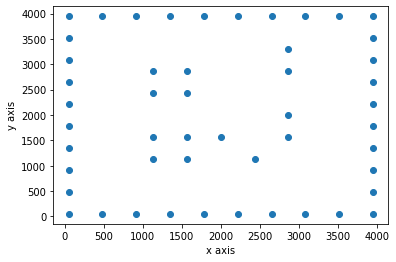

In [172]:
fn_plot(k)

In [86]:
fn_fitness_function(k)

Both perimeter and proximity constraints are satisfied !!

Calculating AEP......
Total power produced by the wind farm is:  548.730539534807 GWh


548.7305395348069

# Submission

In [160]:
k.to_csv("submission.csv",index=False)